In [11]:
import os
import pickle
import re
from collections import Counter

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer

In [78]:
from eval_functions import (
    evaluate_rating_predictions,
    analyze_long_tail_effect,
    plot_avg_error_by_genre,
    plot_avg_error_by_popularity,
    plot_confusion_matrix
)

In [13]:
import random

random.seed(42)

In [14]:
DATA_PATH = "../ml-latest-small"

ratings = pd.read_csv(os.path.join(DATA_PATH, "ratings.csv"))
movies = pd.read_csv(os.path.join(DATA_PATH, "movies.csv"))
tags = pd.read_csv(os.path.join(DATA_PATH, "tags.csv"))

# Unconstrained Matrix Factorisation based Collaborative Filtering (week 7)

In [5]:
df_ecommerce = pd.read_json('../1_ecommerce.jsonl', lines=True)

# for each session, we will create a list of items that the user has clicked on, removing duplicates
clicks_items_list = []
carts_items_list = []
orders_items_list = []

for events in df_ecommerce.events:
    clicks = []
    carts = []
    orders = []
    for e in events:
        if e['type'] == 'clicks':
            clicks.append(e['aid'])
        if e['type'] == 'carts':
            carts.append(e['aid'])
        if e['type'] == 'orders':
            orders.append(e['aid'])

    clicks_items_list.append(list(clicks))
    carts_items_list.append(list(carts))
    orders_items_list.append(list(orders))

df_ecommerce['clicks'] = clicks_items_list
df_ecommerce['carts'] = carts_items_list
df_ecommerce['orders'] = orders_items_list
df = df_ecommerce.drop(columns=["events"], axis=1)

clicks_length = df_ecommerce['clicks'].apply(len)
carts_length = df_ecommerce['carts'].apply(len)
orders_length = df_ecommerce['orders'].apply(len)

# takes only the session with items length higher than 20
df_truncated = df[df['clicks'].apply(lambda x: len(x) > 10)]
df = df_truncated.copy()
# redefine index
df.reset_index(drop=True, inplace=True)

# Explode each column (clicks, carts, orders)
df_clicks = df[['session', 'clicks']].explode('clicks').rename(columns={'clicks': 'item'}).dropna(subset=['item'])
df_carts = df[['session', 'carts']].explode('carts').rename(columns={'carts': 'item'}).dropna(subset=['item'])
df_orders = df[['session', 'orders']].explode('orders').rename(columns={'orders': 'item'}).dropna(subset=['item'])

# Concatenate the exploded dataframes
df_concat = pd.concat([df_clicks, df_carts, df_orders])

# Create a new column for each category indicating whether the item is present in that category
df_concat['click'] = df_concat['item'].isin(df_clicks['item']).astype(int)
df_concat['cart'] = df_concat['item'].isin(df_carts['item']).astype(int)
df_concat['order'] = df_concat['item'].isin(df_orders['item']).astype(int)

# Drop duplicates based on session and item
df_concat = df_concat.drop_duplicates(subset=['session', 'item'])

AttributeError: 'DataFrame' object has no attribute 'events'

In [ ]:
def sgd_matrix_factorization(df, k=10, alpha=0.01, lambda_reg=0.1, num_epochs=20, w_click=1, w_cart=3, w_order=5,
                             test_size=0.2, validation_size=0.1):
    # Map session (users) and items to consecutive indices
    users = {u: i for i, u in enumerate(df['session'].unique())}
    items = {i: j for j, i in enumerate(df['item'].unique())}

    num_users = len(users)
    num_items = len(items)

    # Initialize U, V, and biases
    U = np.random.rand(num_users, k)
    V = np.random.rand(num_items, k)
    b_u = np.zeros(num_users)
    b_i = np.zeros(num_items)
    b = 0  # Global bias

    # Create (u, i, r_ui) tuples for all interactions
    data = []

    # iter throw all the rows of the dataframe
    # and create a list of tuples (user, item, rating)
    # Assign ratings to interactions
    for _, row in df.iterrows():
        u = users[row['session']]
        i = items[row['item']]

        # if this user has perform an action on this item, we assign a rating based on the action
        # type starting from the most important one
        # (order > cart > click)
        if row['order'] > 0:
            r_ui = w_order
        elif row['cart'] > 0:
            r_ui = w_cart
        elif row['click'] > 0:
            r_ui = w_click
        else:
            continue  # Skip interactions with no recorded action

        data.append((u, i, r_ui))

    # Split the data into training, validation, and test sets
    train_data, test_data = train_test_split(data, test_size=test_size, random_state=42)
    train_data, val_data = train_test_split(train_data, test_size=validation_size, random_state=42)

    # Compute global bias as the mean rating of the training set
    if train_data:
        b = np.mean([r for _, _, r in train_data])

    print("Datasets created! Starting training...")

    # Training using SGD
    losses = []
    val_losses = []

    for epoch in range(num_epochs):
        np.random.shuffle(train_data)  # Shuffle data to improve convergence
        total_loss = 0
        total_val_loss = 0

        U_temp = U.copy()
        V_temp = V.copy()

        # Training phase
        for u, i, r_ui in train_data:
            # Predict the rating using the current model parameters
            # b is the global bias, b_u[u] is the user bias, b_i[i] is the item bias
            pred = b + b_u[u] + b_i[i] + np.dot(U[u, :], V[i, :])

            # Calculate the error
            e_ui = r_ui - pred  # Error

            # Update biases
            # alpha is the learning rate, lambda_reg is the regularization parameter
            b_u[u] += alpha * (e_ui - lambda_reg * b_u[u])
            b_i[i] += alpha * (e_ui - lambda_reg * b_i[i])

            # Update latent factors using temporary matrices
            U_temp[u, :] += alpha * (e_ui * V[i, :] - lambda_reg * U[u, :])
            V_temp[i, :] += alpha * (e_ui * U[u, :] - lambda_reg * V[i, :])

            total_loss += e_ui ** 2  # Sum of squared errors
        total_loss /= len(train_data)
        total_loss = np.sqrt(total_loss)

        # Copy back updated matrices
        U = U_temp
        V = V_temp

        # Validation phase (calculate validation loss)
        for u, i, r_ui in val_data:
            pred = b + b_u[u] + b_i[i] + np.dot(U[u, :], V[i, :])
            e_ui = r_ui - pred  # Error
            total_val_loss += e_ui ** 2
        total_val_loss /= len(val_data)
        total_val_loss = np.sqrt(total_val_loss)

        # Append losses for the current epoch
        losses.append(total_loss)
        val_losses.append(total_val_loss)

        print(f"Epoch {epoch + 1}/{num_epochs}, RMSE Train Loss: {total_loss:.4f}, RMSE Val Loss: {total_val_loss:.4f}")

    # Test phase (calculate test loss)
    test_loss = 0
    for u, i, r_ui in test_data:
        pred = b + b_u[u] + b_i[i] + np.dot(U[u, :], V[i, :])
        e_ui = r_ui - pred  # Error
        test_loss += e_ui ** 2
    test_loss /= len(test_data)
    test_loss = np.sqrt(test_loss)

    print(f"Final Test RMSE: {test_loss:.4f}")

    return U, V, b_u, b_i, b, losses, val_losses, test_data

In [ ]:
U, V, b_u, b_i, b, _, _, test_data = sgd_matrix_factorization(df_concat, k=20, alpha=0.001, num_epochs=1, w_click=1,
                                                              w_order=2, w_cart=3)

# Naive Bayes CF Model Based (Week6)

In [55]:
def calculate_prior_probabilities():
    num_items = ratings_matrix.shape[1]
    prior_probs = {}

    for item_idx in range(num_items):
        item_ratings = ratings_matrix[:, item_idx]
        # consider only non-missing ratings
        valid_ratings = item_ratings[~np.isnan(item_ratings)]
        if len(valid_ratings) == 0:
            continue
        # count the number of occurrences of each rating value
        rating_counts = Counter(valid_ratings)
        total_ratings = len(valid_ratings)
        prior_probs[item_idx] = {rating: count / total_ratings for rating, count in rating_counts.items()}

    with open('prior_probs.pkl', 'wb') as f:
        pickle.dump(prior_probs, f)
    return prior_probs

In [56]:
def calculate_conditional_probabilities():
    num_items = ratings_matrix.shape[1]
    conditional_probs = {}

    for item_j in range(num_items):
        # Iterate over each possible rating value vs
        for vs in rating_values:
            # Find users who have rated item j with rating vs
            users_with_vs = np.where((ratings_matrix[:, item_j] == vs))[0]

            # Skip if no users have rated item j with rating vs
            if len(users_with_vs) == 0:
                continue

            conditional_probs[(item_j, vs)] = {}

            # Iterate over all items k
            for item_k in range(num_items):
                # (excluding item j) to calculate conditional probabilities
                if item_k == item_j:
                    continue

                # Find the ratings given by users who rated item j with vs for item k
                ratings_for_k = ratings_matrix[users_with_vs, item_k]
                # Consider only valid (non-NaN) ratings for item k
                valid_ratings = ratings_for_k[~np.isnan(ratings_for_k)]

                # Skip if no valid ratings for item k
                if len(valid_ratings) == 0:
                    continue

                # Count the occurrences of each rating for item k
                rating_counts = Counter(valid_ratings)
                total_ratings = len(valid_ratings)

                # Store the conditional probabilities for item k given item j's rating vs
                conditional_probs[(item_j, vs)][item_k] = {
                    rating: count / total_ratings for rating, count in rating_counts.items()
                }

    with open('conditional_probs.pkl', 'wb') as f:
        pickle.dump(conditional_probs, f)

    return conditional_probs

In [57]:
def predict(user_idx, item_idx, prior_probabilities, conditional_probabilities):
    # Identify items that the user has rated
    observed_items = np.where(~np.isnan(ratings_matrix[user_idx, :]))[0]

    # If no observed ratings or the item is missing from prior probabilities, return None
    if len(observed_items) == 0 or item_idx not in prior_probabilities:
        return None

    posterior_probs = {}  # Dictionary to store posterior probabilities for each rating value

    # Iterate through possible rating values
    for vs in rating_values:

        # Skip if this rating value is not part of the item's prior probabilities
        if vs not in prior_probabilities[item_idx]:
            continue

        prior_prob = prior_probabilities[item_idx][vs]
        conditional_prob_product = 1.0  # Start with a probability product of 1

        # Iterate through observed items to compute the product of conditional probabilities
        for k in observed_items:
            # User's rating for item k
            ruk = ratings_matrix[user_idx, k]

            # Skip if conditional probabilities are missing for this combination
            if (item_idx, vs) not in conditional_probabilities or \
                    k not in conditional_probabilities[(item_idx, vs)] or \
                    ruk not in conditional_probabilities[(item_idx, vs)][k]:
                continue

            # Multiply the conditional probability for this observation
            conditional_prob_product *= conditional_probabilities[(item_idx, vs)][k][ruk]

        # Compute the posterior probability for the current rating value
        posterior_probs[vs] = prior_prob * conditional_prob_product

    # If no valid posterior probabilities were found, return None
    if not posterior_probs:
        return None

    # Compute the weighted average prediction
    numerator = sum(vs * prob for vs, prob in posterior_probs.items())
    denominator = sum(posterior_probs.values())
    return numerator / denominator if denominator > 0 else None

In [61]:
ratings_matrix = ratings.pivot(index="userId", columns="movieId", values="rating").to_numpy()

In [62]:
rating_values = np.unique(ratings_matrix[~np.isnan(ratings_matrix)])
rating_values

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

In [63]:
# convert rating to like/dislike
# ratings_matrix = ratings_matrix.map(lambda x: 1 if x >= 4 else (0 if x <= 2 else np.nan))
# ratings_matrix.head().iloc[:, :10]
# ratings_matrix = ratings_matrix.to_numpy()

In [64]:
prior_probs = calculate_prior_probabilities()
conditional_probs = calculate_conditional_probabilities()
# def load_prior_probabilities():
#     with open('prior_probs.pkl', 'rb') as f:
#         return pickle.load(f)
# 
# def load_conditional_probabilities():
#     with open('conditional_probs.pkl', 'rb') as f:
#         return pickle.load(f)
#     
# prior_probs = load_prior_probabilities()
# conditional_probs = load_conditional_probabilities()

In [65]:
def mask_ratings_matrix(test_ratio=0.2):
    # Initialize a boolean mask for the test set (False by default)
    test_mask = np.zeros_like(ratings_matrix, dtype=bool)

    for user_idx in range(ratings_matrix.shape[0]):
        # Identify items that the user has rated
        rated_items = np.where(~np.isnan(ratings_matrix[user_idx, :]))[0]

        # Ensure the user has rated more than one item (to allow splitting)
        if len(rated_items) > 1:
            # Calculate the number of items to include in the test set
            num_test = max(1, int(test_ratio * len(rated_items)))

            # Randomly select `num_test` items to assign to the test set
            test_indices = np.random.choice(rated_items, size=num_test, replace=False)

            # Mark the selected test items in the mask
            for item_idx in test_indices:
                test_mask[user_idx, item_idx] = True

    return test_mask

In [66]:
test_mask = mask_ratings_matrix(test_ratio=0.2)

# 1. Accuracy metrics on ratings prediction and analyse the effect of the long tail

In [83]:
ratings_copy = ratings.copy()
ratings_copy["prediction"] = np.nan
ratings_copy.head()

,userId,movieId,rating,timestamp,prediction
0,1,1,4.0,964982703,NaN
1,1,3,4.0,964981247,NaN
2,1,6,4.0,964982224,NaN
3,1,47,5.0,964983815,NaN
4,1,50,5.0,964982931,NaN


In [84]:
def evaluate_model(test_matrix, prior_probabilities, conditional_probabilities):
    predictions = []
    actuals = []

    for user_idx in range(ratings_matrix.shape[0]):
        for item_idx in range(ratings_matrix.shape[1]):
            # Check if the item is part of the test set and has a valid rating
            if test_matrix[user_idx, item_idx] and not np.isnan(ratings_matrix[user_idx, item_idx]):
                pred = predict(user_idx, item_idx, prior_probabilities, conditional_probabilities)
                mask = (ratings_copy["userId"] == user_idx) & (ratings_copy["movieId"] == item_idx)
                if mask.any():
                    ratings_copy.loc[mask, "prediction"] = pred

                if pred is not None:
                    predictions.append(pred)
                    actuals.append(ratings_matrix[user_idx, item_idx])

    return actuals, predictions

In [85]:
actuals, predictions = evaluate_model(test_mask, prior_probs, conditional_probs)

In [72]:
predictions[:10]

[1.5000000398801125,
 1.0000000829877125,
 1.0004370459658825,
 2.166648807355179,
 2.8636383193274195,
 0.5000000021361806,
 2.6333333333333546,
 0.5000000288269695,
 2.75,
 1.3333833426207724]

In [75]:
evaluate_rating_predictions(actuals, predictions, threshold=3.5)

{'MAE': 1.636855540233856,
 'RMSE': 1.995951664792834,
 'Accuracy': 0.43051306484778573}

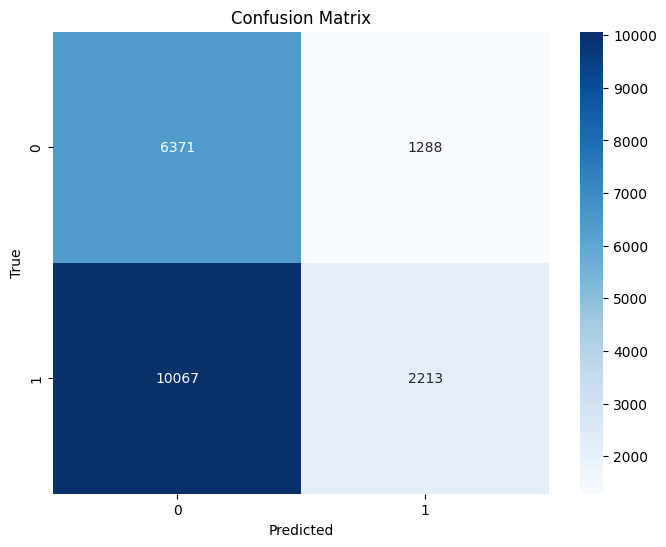

In [79]:
plot_confusion_matrix(actuals, predictions, threshold=3.5)

In [87]:
ratings_copy.head()

,userId,movieId,rating,timestamp,prediction
0,1,1,4.0,964982703,NaN
1,1,3,4.0,964981247,NaN
2,1,6,4.0,964982224,NaN
3,1,47,5.0,964983815,NaN
4,1,50,5.0,964982931,NaN


In [88]:
analyze_long_tail_effect(ratings_copy, prediction_column='prediction')

popularity
head         1.681482
long_tail    1.558254
Name: error, dtype: float64

In [89]:
ratings_copy.head()

,userId,movieId,rating,timestamp,prediction,popularity,error
0,1,1,4.0,964982703,NaN,head,NaN
1,1,3,4.0,964981247,NaN,head,NaN
2,1,6,4.0,964982224,NaN,head,NaN
3,1,47,5.0,964983815,NaN,head,NaN
4,1,50,5.0,964982931,NaN,head,NaN


# 2.Visualize the average error per movie category and movie popularity

In [94]:
import matplotlib.pyplot as plt

def plot_avg_error_by_genre(ratings_df, movies_df, prediction_column='predicted_rating'):
    df = pd.merge(ratings_df, movies_df, on='movieId')
    df['genres'] = df['genres'].str.split('|')
    df = df.explode('genres')
    df['error'] = abs(df['rating'] - df[prediction_column])
    genre_error = df.groupby('genres')['error'].mean()
    genre_error.plot(kind='bar', figsize=(12, 6), title='Average Error per Genre')
    plt.show()


def plot_avg_error_by_popularity(ratings_df, prediction_column='predicted_rating'):
    movie_counts = ratings_df['movieId'].value_counts()
    ratings_df['popularity_bin'] = pd.qcut(ratings_df['movieId'].map(movie_counts), q=3,
                                           labels=['Low', 'Medium', 'High'])
    ratings_df['error'] = abs(ratings_df['rating'] - ratings_df[prediction_column])
    pop_error = ratings_df.groupby('popularity_bin')['error'].mean()
    pop_error.plot(kind='bar', figsize=(8, 5), title='Error by Popularity Bin')
    plt.show()

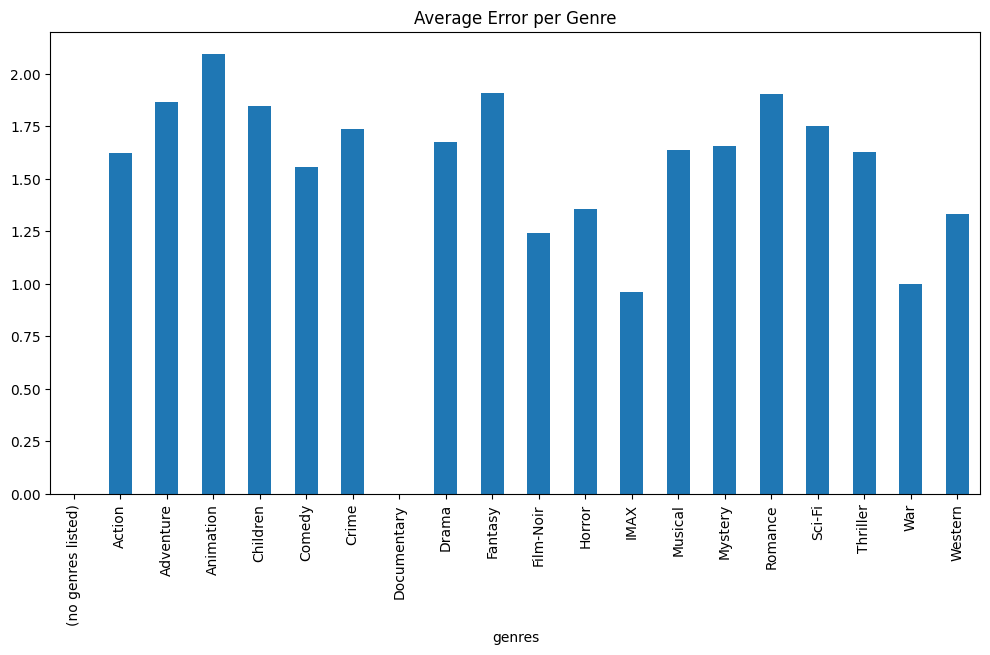

In [95]:
plot_avg_error_by_genre(ratings_copy, movies, prediction_column='prediction')

/tmp/ipykernel_10627/1046022393.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pop_error = ratings_df.groupby('popularity_bin')['error'].mean()


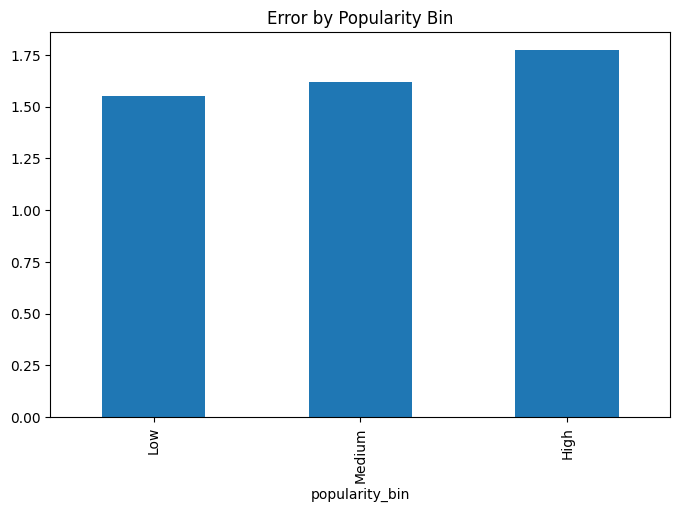

In [97]:
plot_avg_error_by_popularity(ratings_copy, prediction_column='prediction')

In [10]:
# def test_naive_cf_model_based(df_test, df_train_user_movie):
# 
#     df_predictions = df_test.copy()
# 
#     for idx, row in enumerate(df_predictions.itertuples()):
#         userId = row.userId
#         movieId = row.movieId
# 
#         # Film visti dall'utente, dai dati di TRAIN
#         try:
#             films_seen = df_train_user_movie.loc[userId].dropna().index
#         except KeyError:
#             # Utente non presente nel train (cold start) → skip
#             continue
# 
#         category_probs = {}
# 
#         for category in ratings_ordinals:
#             df_current_movie = train[(train['movieId'] == movieId)]
#             df_current_movie_category = df_current_movie[(df_current_movie['rating_ordinal'] == category)]
# 
#             if len(df_current_movie) == 0:
#                 continue  # impossibile stimare, nessuno ha votato il film
# 
#             users_with_category = df_current_movie_category['userId'].unique()
# 
#             p_cat = len(df_current_movie_category) / len(df_current_movie)
#             probs = [p_cat]
# 
#             for film_seen in films_seen:
#                 try:
#                     assigned_rating = df_train_user_movie.loc[userId, film_seen]
#                 except KeyError:
#                     continue  # Film non presente per quell’utente
# 
#                 df_seen_movie = train[train['movieId'] == film_seen]
#                 df_seen_movie_filtered = df_seen_movie[df_seen_movie['userId'].isin(users_with_category)]
#                 df_seen_movie_same_rating = df_seen_movie_filtered[df_seen_movie_filtered['rating_ordinal'] == assigned_rating]
# 
#                 if len(df_seen_movie_filtered) == 0:
#                     continue
# 
#                 p_cond = len(df_seen_movie_same_rating) / len(df_seen_movie_filtered)
#                 probs.append(p_cond)
# 
#             category_probs[category] = np.prod(probs)
# 
#         if category_probs:
#             predicted = max(category_probs.items(), key=lambda x: x[1])[0]
#             df_predictions.loc[(df_predictions['userId'] == userId) & (df_predictions['movieId'] == movieId), 'predicted'] = predicted
# 
#         if idx % 50 == 0:
#             print(f"Processed {idx}/{len(df_predictions)}")
# 
#     return df_predictions

In [11]:
# df_predictions = test_naive_cf_model_based(df_test, df_train_user_movie)

In [12]:
# df_predictions.head(10)

In [13]:
# from sklearn.metrics import classification_report
# 
# # Skipping the NaN values (where we don't have that user in train / film without ratings)
# df_predictions.dropna(subset=['predicted'], inplace=True)

In [14]:
# df_predictions['rating_label'] = df_predictions['rating_ordinal'].map({
#     "Don't like": 0,
#     "Like": 1
# })
# 
# df_predictions['pred_label'] = df_predictions['predicted'].map({
#     "Don't like": 0,
#     "Like": 1
# })
# 
# print(classification_report(df_predictions['rating_label'], df_predictions['pred_label']))

# Bayes Classification Content-based (week 8)

In [98]:
## Preprocess Movie Metadata
tags_agg = tags.copy().groupby("movieId")["tag"].apply(lambda x: " ".join(x)).reset_index()
movies_df = movies.copy().merge(tags_agg, on="movieId", how="left")
movies_df["tag"] = movies_df["tag"].fillna("")

#### 1. User-Specific Naive Bayes Recommender

In [112]:
# Clean the title by removing the year in parentheses
def clean_title(title):
    return re.sub(r'\s*\(\d{4}\)', '', title)


metadata = movies_df[["movieId", "title", "genres"]]
metadata.loc[:, 'title'] = metadata['title'].apply(clean_title)

mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(metadata['genres'].str.split('|'))
# Create a DataFrame with the encoded genres
genres_df = pd.DataFrame(genres_encoded, columns=mlb.classes_)
# Concatenate the original metadata with the encoded genres
metadata = pd.concat([metadata[['movieId', 'title']], genres_df], axis=1)

tfidf = TfidfVectorizer(max_features=1000, stop_words='english')

# Create a preprocessor that transforms the movie metadata:
# - Applies TF-IDF vectorization to the cleaned 'title' column to extract textual features.
# - Passes through the binary genre columns (already transformed by MultiLabelBinarizer).
# - Drops any remaining columns that are not explicitly selected.
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', tfidf, 'title'),
        ('genres', 'passthrough', genres_df.columns)
    ],
    remainder='drop'
)

In [113]:
def predict_single_movie(user_id, movie_id, threshold=3.5):
    ratings = ratings_train.copy()

    # Step 1: Prepare user data
    user_ratings = ratings[ratings['userId'] == user_id]
    user_data = pd.merge(user_ratings, metadata, on='movieId')

    # Step 2: Create binary labels
    user_data['label'] = user_data['rating'].apply(lambda r: 1 if r >= threshold else (0 if r < threshold else None))
    user_data = user_data.dropna(subset=['label'])
    user_data['label'] = user_data['label'].astype(int)

    if user_data.empty:
        print("User has insufficient data.")
        return None

    # Step 3: Train the model
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', MultinomialNB())
    ])

    X_train = user_data.drop(columns=['userId', 'rating', 'label', 'timestamp', 'rating_ordinal'])
    y_train = user_data['label']

    pipeline.fit(X_train, y_train)

    # Step 4: Check if the movie has already been watched
    if movie_id in user_ratings['movieId'].values:
        print("The movie has already been watched by the user.")
        return None

    # Step 5: Extract features of the requested movie
    movie_row = metadata[metadata['movieId'] == movie_id]

    if movie_row.empty:
        print("Movie ID not found in the metadata.")
        return None

    input_cols = list(X_train.columns)
    movie_features = movie_row[input_cols]

    # Step 6: Predict the probability of liking the movie
    probs = pipeline.predict_proba(movie_features)[0]  # P(liked | features)
    if len(probs) < 2:
        print(f"The model for user {user_id} has seen only one class (not like/like).")
        return None
    else:
        prob = probs[1]

    return "Like" if prob >= 0.5 else "Don't like"

In [107]:
def evaluate_all_users(ratings_matrix, ratings_train):
    actuals = []
    predictions = []

    user_ids = ratings_matrix.index
    movie_ids = ratings_matrix.columns

    for user_id in user_ids:
        for movie_id in movie_ids:
            rating = ratings_matrix.loc[user_id, movie_id]

            # Skip if no actual rating
            if pd.isna(rating):
                continue

            # Convert to binary label: 1 = Like (rating >= 4), 0 = Dislike (rating <= 2), else skip
            if rating >= 4:
                actual = 1
            elif rating <= 2:
                actual = 0
            else:
                continue  # ambiguous rating (e.g., 3)

            # Predict using your custom function
            pred_label = predict_single_movie(user_id, movie_id, ratings_train)
            
            mask = (ratings_copy["userId"] == user_id) & (ratings_copy["movieId"] == movie_id)
            if mask.any():
                ratings_copy.loc[mask, "prediction"] = pred_label

            # Convert prediction to binary: "Like" → 1, "Don't like" → 0
            if pred_label is not None:
                pred = 1 if pred_label == "Like" else 0
                actuals.append(actual)
                predictions.append(pred)

    return actuals, predictions

In [110]:
ratings_matrix = ratings.pivot(index="userId", columns="movieId", values="rating")

In [111]:
actuals, predictions = evaluate_all_users(ratings_matrix, test_mask)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

#### 2. Global Content-Based Recommender (Single Model for All Users)

In [19]:
metadata_with_tags = metadata.merge(movies_df[["movieId", "tag"]], on='movieId', how='left')

preprocessor_global = ColumnTransformer(
    transformers=[
        ('tfidf', tfidf, 'title'),
        ('genres', 'passthrough', genres_df.columns),
        ('tfidf_tag', tfidf, 'tag')
    ],
    remainder='drop'
)

In [20]:
def train_global_model(ratings_train):
    ratings = ratings_train.copy()
    # Step 1: Prepare data
    data = pd.merge(ratings, metadata_with_tags, on='movieId')

    # Step 2: Create binary labels
    data['label'] = data['rating'].apply(lambda r: 1 if r >= 4 else (0 if r <= 2 else None))
    data = data.dropna(subset=['label'])
    data['label'] = data['label'].astype(int)

    # Step 3: Train the model
    pipeline = Pipeline([
        ('preprocessor', preprocessor_global),
        ('classifier', MultinomialNB())
    ])

    X = data.drop(columns=['userId', 'movieId', 'rating', 'label', 'timestamp', 'rating_ordinal'])
    y = data['label']

    model = pipeline.fit(X, y)
    return model, X.columns


model_global, train_columns = train_global_model(df_train)


def recommend_global(user_id, movie_id, ratings_train):
    ratings = ratings_train.copy()

    # Step 4: Check if the movie has already been watched
    user_ratings = ratings[ratings['userId'] == user_id]
    if movie_id in user_ratings['movieId'].values:
        print("The movie has already been watched by the user.")
        return None

    # Step 5: Extract features of the requested movie
    movie_row = metadata_with_tags[metadata_with_tags['movieId'] == movie_id]

    if movie_row.empty:
        print("Movie ID not found in the metadata.")
        return None
    movie_features = movie_row[train_columns]

    # Step 6: Predict the probability of liking the movie
    probs = model_global.predict_proba(movie_features)[0]  # P(liked | features)
    if len(probs) < 2:
        print(f"The model for user {user_id} has seen only one class (not like/like).")
        return None
    else:
        prob = probs[1]

    return "Like" if prob >= 0.5 else "Don't like"

NameError: name 'df_train' is not defined

In [21]:
recommend_global(user_id=chosen_user, movie_id=chosen_film, ratings_train=df_train)

NameError: name 'recommend_global' is not defined

In [22]:
def test_naive_cf_content_based(df_param, df_train):
    df_tmp = df_param.copy()

    preds_user = []
    preds_global = []
    for idx, row in enumerate(df_tmp.itertuples()):
        userId = row.userId
        movieId = row.movieId

        pred_user = predict_single_movie(userId, movieId, ratings_train=df_train)
        pred_global = recommend_global(userId, movieId, ratings_train=df_train)

        preds_user.append(pred_user)
        preds_global.append(pred_global)
        # df_tmp.loc[(df_predictions['userId'] == userId) & (df_predictions['movieId'] == movieId), 'pred_user'] = pred_user
        # df_tmp.loc[(df_predictions['userId'] == userId) & (df_predictions['movieId'] == movieId), 'pred_glob'] = pred_global

    return preds_user, preds_global

In [23]:
df_predictions.head()

NameError: name 'df_predictions' is not defined

In [24]:
u, g = test_naive_cf_content_based(df_predictions, df_train=df_train)

NameError: name 'df_predictions' is not defined

In [25]:
len(u), len(df_predictions)

NameError: name 'u' is not defined

# Evaluation

In [ ]:
from eval_functions import (
    evaluate_rating_predictions,
    analyze_long_tail_effect,
    plot_avg_error_by_genre,
    plot_avg_error_by_popularity,
    evaluate_ranking_spearman,
    evaluate_topk,
    plot_precision_recall_roc,
    evaluate_random_recommender
)

## 1. Accuracy metrics on ratings prediction and analyse the effect of the long tail

In [26]:
# Supponiamo che ratings contenga una colonna 'predicted_rating' già calcolata
# In caso contrario, puoi usare un modello qualsiasi per generarla

# ESEMPIO: Accuracy + Long Tail
metrics = evaluate_rating_predictions(ratings['rating'], ratings['predicted_rating'])
print("Valutazione globale:", metrics)

long_tail_errors = analyze_long_tail_effect(ratings, prediction_column='predicted_rating')
print("Errore medio long tail vs head:\n", long_tail_errors)

# ESEMPIO: Visualizzazione errori
plot_avg_error_by_genre(ratings, movies)
plot_avg_error_by_popularity(ratings)

# ESEMPIO: Ranking Spearman per un utente
user_id = ratings['userId'].sample(1).values[0]
user_df = ratings[ratings['userId'] == user_id]
correlation = evaluate_ranking_spearman(user_df['rating'], user_df['predicted_rating'])
print(f"Spearman correlation per l'utente {user_id}: {correlation:.3f}")

# ESEMPIO: Top-k evaluation (supponendo y_true e y_scores binari)
# Qui facciamo un esempio fittizio
true_items = set(user_df[user_df['rating'] >= 4]['movieId'])
all_items = list(user_df['movieId'])
scores = list(user_df['predicted_rating'])

# Costruiamo y_true binario: 1 se è un item rilevante
y_true = [1 if item in true_items else 0 for item in all_items]

topk_result = evaluate_topk(y_true, scores, k=10)
print("Top-K Evaluation:", topk_result)

# Curve Precision-Recall e ROC
plot_precision_recall_roc(y_true, scores)

# ESEMPIO: Benchmark con Random Recommender
random_baseline = evaluate_random_recommender(true_items, all_items, k=10)
print("Random Recommender Benchmark:", random_baseline)

KeyError: 'predicted_rating'

In [ ]:
models_outputs = {
    'Global Naive Bayes': df_global_nb,
    'User Naive Bayes': df_user_nb,
    'Matrix Factorization': df_mf,
    'Random': df_random
}

for name, df in models_outputs.items():
    print(f"\n============================")
    print(f"📊 Risultati per: {name}")

    # Valutazione classica
    metrics = evaluate_rating_predictions(df['rating'].dropna(), df['predicted_rating'].dropna())
    print("📌 Accuracy:", metrics)

    # Long Tail
    long_tail = analyze_long_tail_effect(df.dropna(subset=['rating']))
    print("🐍 Long Tail Error:")
    print(long_tail)

    # Top-K Example su un utente qualsiasi (solo se abbiamo ground truth)
    sample_user = df['userId'].iloc[0]
    user_df = df[df['userId'] == sample_user].dropna(subset=['rating'])

    if not user_df.empty:
        # costruiamo y_true e scores
        true_items = set(user_df[user_df['rating'] >= 4]['movieId'])
        movie_ids = user_df['movieId'].tolist()
        scores = user_df['predicted_rating'].tolist()
        y_true = [1 if m in true_items else 0 for m in movie_ids]

        topk = evaluate_topk(y_true, scores, k=10)
        print("🎯 Top-K:", topk)

        # Correlazione ranking
        spearman = evaluate_ranking_spearman(user_df['rating'], user_df['predicted_rating'])
        print(f"🔗 Spearman correlation: {spearman:.3f}")

        # Curve
        plot_precision_recall_roc(y_true, scores)
